# Visualize flux footprint data from NetCDF files. 


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


file_dir = "/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/resnc/"
file_list = [os.path.join(root, f) for root, _, files in os.walk(file_dir) for f in files if f.endswith('.nc')]
len(file_list)



317

## Read data

In [2]:
def process_file(file):
    ds = xr.open_dataset(file)
    df = pd.DataFrame({
        "time": pd.to_datetime(ds["time"].values),  # Convert to datetime
        "wind_dir": ds["wind_dir"].values,
        "co2_flux": ds["co2_flux"].values,
        "x_peak": ds["x_peak"].values,
        "x_10": ds["x_10%"].values,
        "x_30": ds["x_30%"].values,
        "x_50": ds["x_50%"].values,
        "x_70": ds["x_70%"].values,
        "x_90": ds["x_90%"].values,
        "wind_speed": ds["wind_speed"].values,
    })
    ds.close()
    return df

# conmine DataFrame
all_data = pd.concat([process_file(file) for file in file_list], ignore_index=True)
all_data.head()


,time,wind_dir,co2_flux,x_peak,x_10,x_30,x_50,x_70,x_90,wind_speed
0,2024-10-18 00:30:00,146.096,33.1705,33.4682,30.0000,60.000,110.000,229.000,897.000,1.28076
1,2024-10-18 01:00:00,143.942,64.0871,172.1010,59.0767,147.109,224.351,314.656,471.411,1.49191
2,2024-10-18 01:30:00,145.209,43.2314,141.7200,48.6479,121.140,184.746,259.110,388.193,1.41608
3,2024-10-18 02:00:00,155.888,50.2664,183.6540,63.0424,156.984,239.411,335.777,503.056,1.09819
4,2024-10-18 02:30:00,174.626,4.3821,187.8970,64.4989,160.611,244.942,343.535,514.678,1.18225


Define a helper function to compute Cartesian coordinates based on the along-wind distance and wind direction.

In [3]:
# Cartesian coordinates
def compute_xy(distance, angle_rad):
    x = distance * np.cos(angle_rad)
    y = distance * np.sin(angle_rad)
    return x, y

# level by level  
for perc in ["10", "30", "50", "70", "90"]:
    all_data[f"x_{perc}_x"], all_data[f"x_{perc}_y"] = compute_xy(
        all_data[f"x_{perc}"], 
        np.radians(all_data["wind_dir"])
    )


### Scatter Plots of Flux Footprints

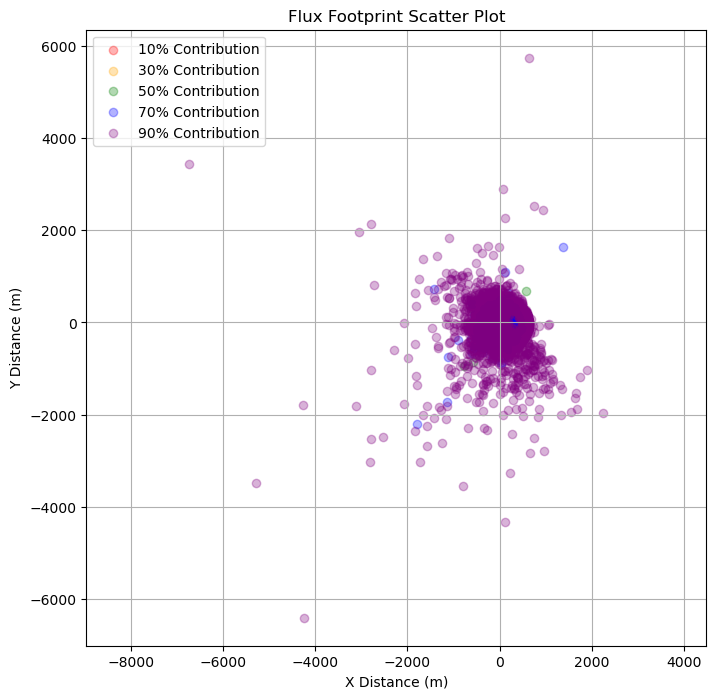

In [4]:
plt.figure(figsize=(8, 8))
colors = ['red', 'orange', 'green', 'blue', 'purple']
percentages = ['10%', '30%', '50%', '70%', '90%']
x_vars = [f"x_{p}_x" for p in ["10", "30", "50", "70", "90"]]
y_vars = [f"x_{p}_y" for p in ["10", "30", "50", "70", "90"]]

for x_var, y_var, color, perc in zip(x_vars, y_vars, colors, percentages):
    plt.scatter(all_data[x_var], all_data[y_var], alpha=0.3, color=color, label=f"{perc} Contribution")

plt.title("Flux Footprint Scatter Plot")
plt.xlabel("X Distance (m)")
plt.ylabel("Y Distance (m)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


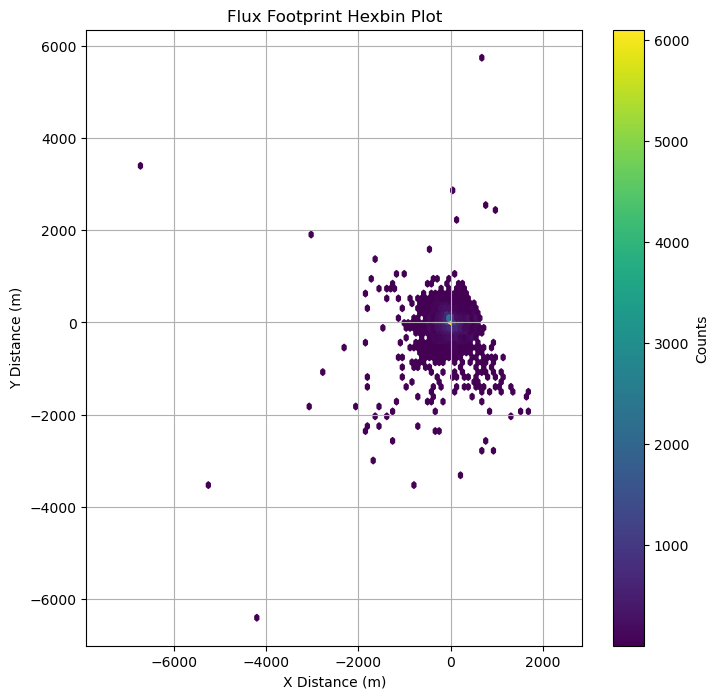

In [12]:
plt.figure(figsize=(8, 8))
all_x = np.concatenate([all_data[var] for var in x_vars])
all_y = np.concatenate([all_data[var] for var in y_vars])

plt.hexbin(all_x, all_y, gridsize=100, cmap="viridis", mincnt=1)
plt.colorbar(label="Counts")
plt.title("Flux Footprint Hexbin Plot")
plt.xlabel("X Distance (m)")
plt.ylabel("Y Distance (m)")
plt.axis("equal")
plt.grid(True)
plt.show()


## Polar Plot cumulative flux contributions by wind speed range.

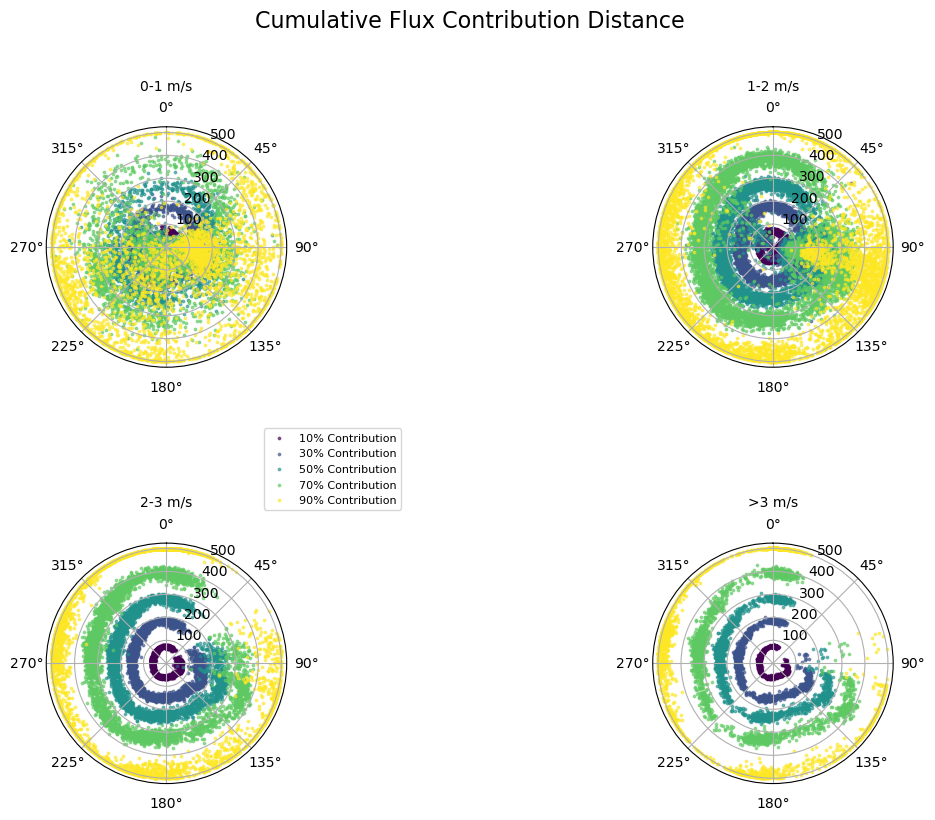

In [5]:
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Wind speed ranges
bins = [0, 1, 2, 3, np.inf]
labels = ["0-1 m/s", "1-2 m/s", "2-3 m/s", ">3 m/s"]
all_data["wind_speed_range"] = pd.cut(all_data["wind_speed"], bins=bins, labels=labels, ordered=True)

norm = Normalize(vmin=0, vmax=4)  # Normalize for 5 levels (10%, 30%, ..., 90%)
colors = [viridis(norm(i)) for i in range(5)]

# Create facet grid
n_panels = len(labels)
fig, axes = plt.subplots(
    nrows=(n_panels + 1) // 2, ncols=2, subplot_kw={"projection": "polar"}, figsize=(12, 8)
)
axes = axes.flatten()

# 0  at the top
for ax in axes:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise 

for i, label in enumerate(labels):
    ax = axes[i]
    data_subset = all_data[all_data["wind_speed_range"] == label]
    for idx, perc in enumerate(["10", "30", "50", "70", "90"]):
        ax.scatter(
            np.radians(data_subset["wind_dir"]),  # FROM direction
            np.minimum(data_subset[f"x_{perc}"], 500),
            s=3,
            alpha=0.6,
            label=f"{perc}% Contribution",
            color=colors[idx],  
        )
    ax.set_title(label, va="bottom", fontsize=10)
    if i == 2:  # Add legend only to the first panel
        ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1.5), fontsize=8)

for ax in axes[len(labels):]:
    fig.delaxes(ax)

plt.suptitle("Cumulative Flux Contribution Distance", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
